# Ensemble Learning
https://www.geeksforgeeks.org/stacking-in-machine-learning-2/
https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

**Load files**

In [14]:
%run Preprocessing.ipynb

(1549, 100)
(665, 100)


In [15]:
# import packages
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.layers import Dropout, Dense
from keras.models import Sequential
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [16]:
# Load train and test sets from Preprocessing file
x_train = x_train
y_train = y_train
x_test = x_test
y_test = y_test

In [17]:
# Set classes based on classification complexity decided in pre-processing
classes = {'LowCrime': 0, 'HighCrime': 1}

In [108]:
# Load function for plotting confusion matrix
def plot_confusion_matrix(train_pred, train, dom):
    cf = confusion_matrix(train_pred,train)
    sns.heatmap(cf,annot=True,yticklabels=classes,xticklabels=classes,cmap='Blues', fmt='g')
    plt.title(f'{dom} Confusion matrix')
    plt.tight_layout()
    plt.figure(figsize=(1, 2), dpi=80)
    plt.show()
    

**Paste Models from Files**

In [19]:
# Function for neural networks

def create_model(optimizer='Adagrad', init='glorot_uniform', neurons=12, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(neurons, input_dim=100, kernel_initializer='uniform', activation='linear', kernel_constraint=maxnorm(4)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid')) # kernel_initializer=init
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [48]:
# Load models from files, but for now...
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_split = 0.1, max_features=70, ccp_alpha=0.01, splitter = 'best')
svm_model = SVC(C=1, gamma=0.1, probability=True)
b_model = BernoulliNB(alpha=1, binarize=None)
nn_model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=5, verbose=0)
nn_model._estimator_type = "classifier"

**Implement Ensemble Voting Classifier**

Parameters
- voting = If ‘hard’, uses predicted class labels for majority rule voting. Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.
- weights = Sequence of weights (float or int) to weight the occurrences of predicted class labels (hard voting) or class probabilities before averaging (soft voting). Uses uniform weights if None.
- n_jobs = The number of jobs to run in parallel for fit. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.
- flatten_transform = Affects shape of transform output only when voting=’soft’ If voting=’soft’ and flatten_transform=True, transform method returns matrix with shape (n_samples, n_classifiers * n_classes). If flatten_transform=False, it returns (n_classifiers, n_samples, n_classes).
- verbose = If True, the time elapsed while fitting will be printed as it is completed.

In [62]:
# Fit & Train model
voting_clf = VotingClassifier(estimators=[('SVC', svm_model), ('DTree', dt_model), ('Bayes', b_model), ('NN', nn_model)], voting='soft')
voting_clf.fit(x_train, y_train)
voting_clf.score(x_test, y_test)

0.8721804511278195

**Perform k-fold cross validation**

Ensemble Train Model Accuracy(in %): 86.8302130406714
Ensemble Test Model Accuracy(in %): 87.21804511278195


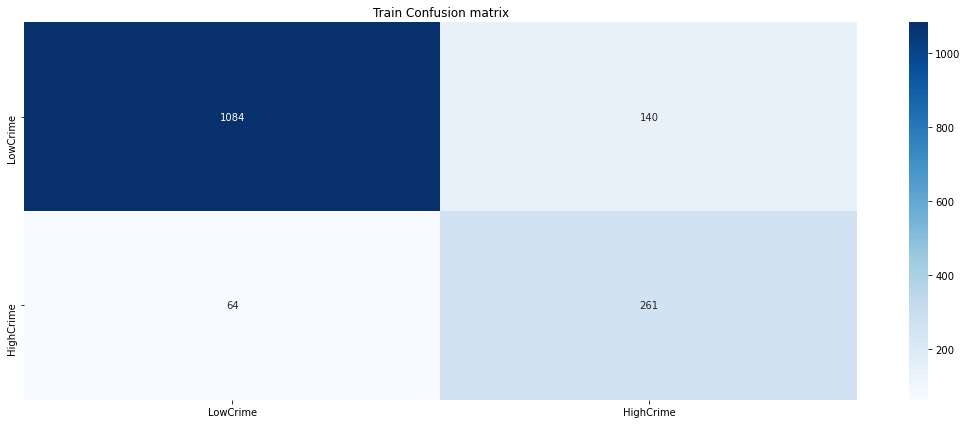

<Figure size 80x160 with 0 Axes>

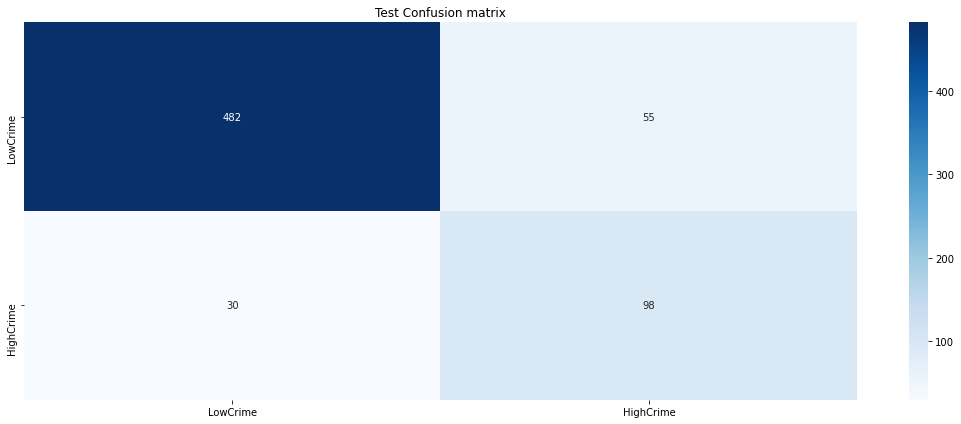

<Figure size 80x160 with 0 Axes>

In [109]:
# Compare train &  test data
y_train_pred = voting_clf.predict(x_train)
y_test_pred = voting_clf.predict(x_test)

print(f'Ensemble Train Model Accuracy(in %): {accuracy_score(y_train_pred,y_train)*100}')
print(f'Ensemble Test Model Accuracy(in %): {accuracy_score(y_test_pred,y_test)*100}')
plot_confusion_matrix(y_train_pred,y_train,dom='Train')
plot_confusion_matrix(y_test_pred,y_test,dom='Test')

In [61]:
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from matplotlib import pyplot


def get_models():
    models = dict()
    models['Decision tree'] = dt_model
    models['svm'] = svm_model
    models['GaussianNB'] = b_model
    #model['NN'] = nn_model
#     models['stacking'] = voting_clf
    return models

models = get_models()

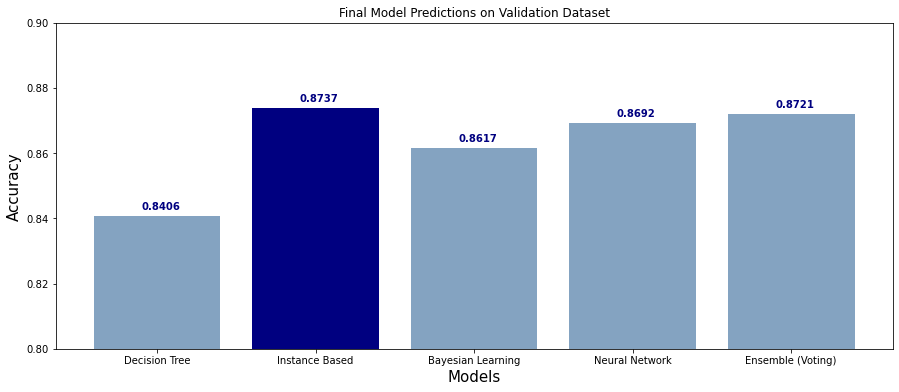

In [98]:
x = ['Decision Tree', 'Instance Based', 'Bayesian Learning', 'Neural Network', 'Ensemble (Voting)']
y = [0.8406, 0.8737, 0.8617, 0.8692, 0.8721]
color=(0.2, 0.4, 0.6, 0.6)

plt.bar(x, y, color=[color, 'navy', color, color, color])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(0.8, 0.9)
plt.title('Final Model Predictions on Validation Dataset')
for i, v in enumerate(y):
    plt.text(i-0.1, v +0.002, str(v), color='navy', fontweight='bold')

[0.87969925 0.82706767 0.78195489 0.85714286 0.81954887 0.81203008
 0.81203008 0.88721805 0.81954887 0.79699248 0.81203008 0.80451128
 0.82706767 0.84210526 0.81203008]
>Decision tree -> 0.826 (0.028)---Crime dataset


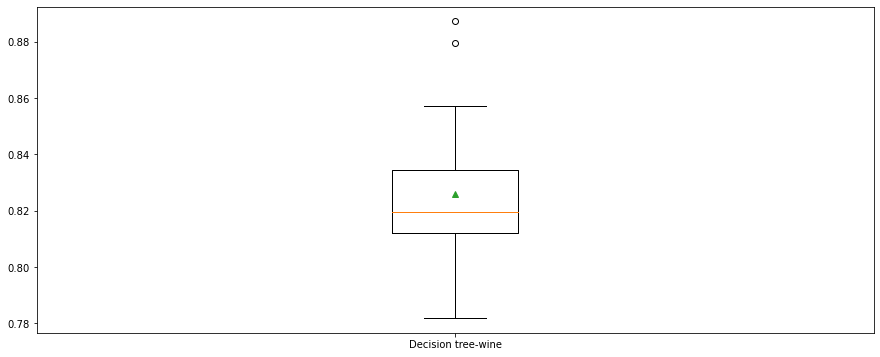

[0.88721805 0.83458647 0.82706767 0.90225564 0.85714286 0.84962406
 0.82706767 0.89473684 0.85714286 0.87218045 0.84962406 0.85714286
 0.85714286 0.91729323 0.84962406]
>svm -> 0.863 (0.026)---Crime dataset


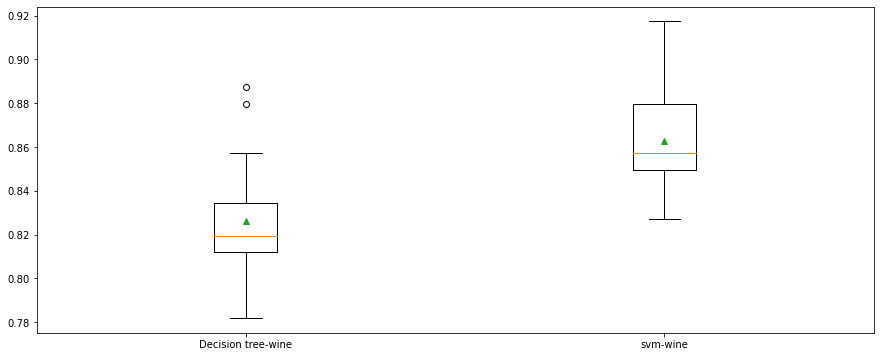

[0.90977444 0.84210526 0.84210526 0.88721805 0.84962406 0.85714286
 0.83458647 0.89473684 0.85714286 0.87969925 0.82706767 0.85714286
 0.84962406 0.87969925 0.87218045]
>GaussianNB -> 0.863 (0.023)---Crime dataset


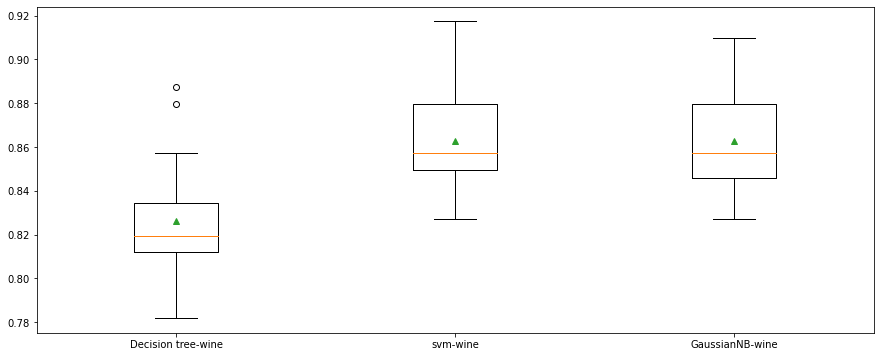

In [58]:
# creating lists to store the results
results, names, results1 = list(), list(), list()

def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits =5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print(scores)
    return scores

for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s -> %.3f (%.3f)---Crime dataset' % (name, mean(scores), std(scores)))
    pyplot.rcParams["figure.figsize"] = (15,6)
    pyplot.boxplot(results, labels=[s+"-wine" for s in names], showmeans=True)
    pyplot.show()